Fashion-MNIST is a dataset of Zalando’s article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. It is split in 10,000 as test and 50,000 as train datasets

Each training and test example is assigned to one of the following labels:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, BatchNormalization ,AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from keras.datasets import fashion_mnist
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input

# !pip install -q -U keras-tuner
import keras_tuner as kt

In [2]:
print('GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

GPUs Available:  0


In [3]:
tf.test.is_built_with_cuda()

False

In [4]:
(x_train, Y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [6]:
print("Fashion MNIST train shape:",x_train.shape," Label Shape Train : ",Y_train.shape)
print("Fashion MNIST test shape:",x_test.shape," Label Shape Train : ",y_test.shape)

Fashion MNIST train shape: (60000, 28, 28)  Label Shape Train :  (60000,)
Fashion MNIST test shape: (10000, 28, 28)  Label Shape Train :  (10000,)


In [7]:
np.unique(Y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

# Visualize the Data using pie chart


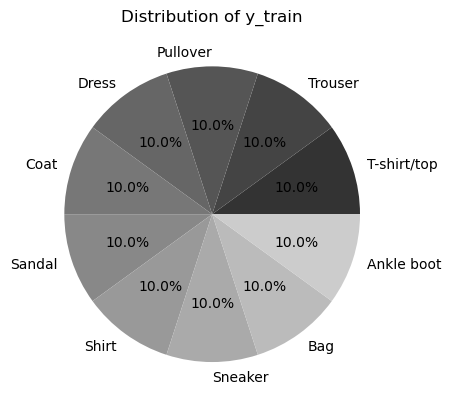

In [8]:
# Define the class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Count the number of samples per class
counts = np.bincount(Y_train)

# Get a grayscale colormap
cmap = plt.get_cmap('gray')

# Plot the pie chart with grayscale colors
plt.pie(counts, labels=class_names, autopct='%1.1f%%', colors=cmap(np.linspace(0.2, 0.8, 10)))
plt.title('Distribution of y_train')
plt.show()

# Some of Images


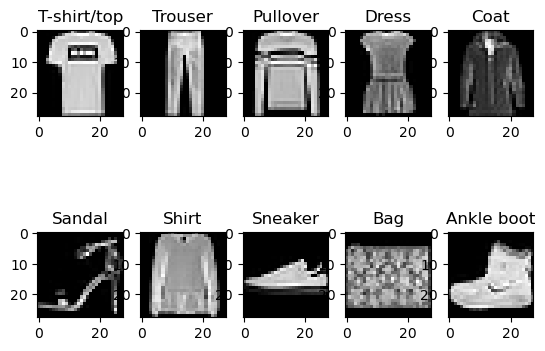

In [9]:
for i in range(10):
    # Find the index of the first image of class i
    index = np.where(Y_train == i)[0][0]
    # Plot the image with the class name as title
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[index], cmap='gray')
    plt.title(class_names[i])
plt.show()

# Checking for null and dublicates

In [10]:
x_train_df = pd.DataFrame(x_train.reshape(-1, 28*28))

# Check for null values
x_train_df.isnull().sum().sum()

0

In [11]:
x_train_df.duplicated().sum()

0

In [1]:
corr = x_train_df.corr()
corr.style.background_gradient(cmap="RdBu_r")

# Preprocessing
## Reshape and Normalize Each Row of Dataset on traning and testing

In [12]:
# data preprocessing
def data_Reshape_Normalize(DataX):
    DataX = DataX.reshape((DataX.shape[0], 28, 28, 1)) #reshape
    out_x = DataX / 255 # Normlize the data
    return out_x 

X=data_Reshape_Normalize(x_train)
X_Test=data_Reshape_Normalize(x_test)   

In [13]:
print("Fashion MNIST train shape:",X.shape," Label Shape Train : ",Y_train.shape)
print("Fashion MNIST test shape:",X_Test.shape," Label Shape Train : ",y_test.shape)

Fashion MNIST train shape: (60000, 28, 28, 1)  Label Shape Train :  (60000,)
Fashion MNIST test shape: (10000, 28, 28, 1)  Label Shape Train :  (10000,)


In [14]:
X_train, X_val, y_train, y_val = train_test_split(X,Y_train,stratify=Y_train,test_size = 0.2,random_state=1)

# LeNet-5 Architecture without Tunning HyperParamters

The famous LeNet-5 architecture had the following layers:

Layer  | Type            | Maps | Size     | Kernel size | Stride | Activation
-------|-----------------|------|----------|-------------|--------|-----------
 Out   | Fully connected | –    | 10       | –           | –      | RBF
 F6    | Fully connected | –    | 84       | –           | –      | tanh
 C5    | Convolution     | 120  | 1 × 1    | 5 × 5       | 1      | tanh
 S4    | Avg pooling     | 16   | 5 × 5    | 2 × 2       | 2      | tanh
 C3    | Convolution     | 16   | 10 × 10  | 5 × 5       | 1      | tanh
 S2    | Avg pooling     | 6    | 14 × 14  | 2 × 2       | 2      | tanh
 C1    | Convolution     | 6    | 28 × 28  | 5 × 5       | 1      | tanh
 In    | Input           | 1    | 32 × 32  | –           | –      | –
 
ref : hands on machine learning 3rd edition chapter 14 LeNet-5 architecture

In [15]:
model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(28, 28, 1)))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(5, 5), activation='tanh'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(120, activation='tanh'))
model.add(Dense(84, activation='tanh'))
model.add(Dense(10, activation='softmax'))
model.build()
model.summary()

adam = Adam(learning_rate=5e-4)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=adam)
# learning rate annealer
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.2,min_lr=1e-6)
# Data Augmentation
dataAug = ImageDataGenerator(rotation_range=10,width_shift_range=0.1,height_shift_range=0.1, zoom_range=0.1)
dataAug.fit(X_train)
history =model.fit(dataAug.flow(X_train, y_train, batch_size=128), 
                    epochs=30, validation_data=(X_val, y_val), callbacks=[reduce_lr,callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 4, 4, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 120)               3

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


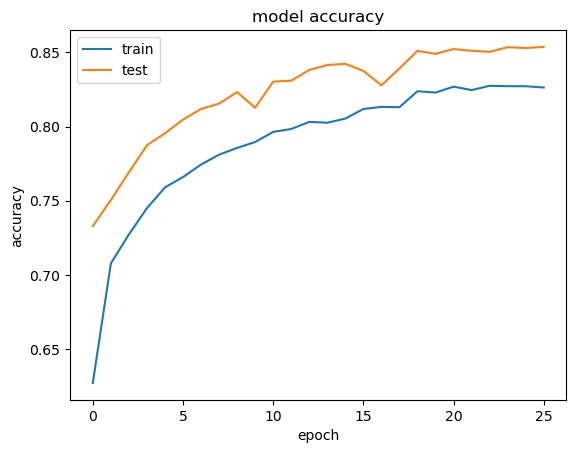

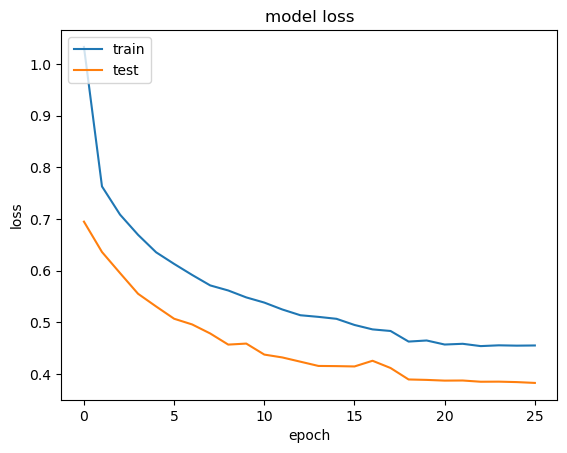

In [16]:
# plot graphs for the native archiecture
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# LeNet-5 Architecture With keras tuner HyberBand Tunning HyperParamters


- Activation Function 
- learning rate
- number of filters
- padding
- number of units in each hidden layer

In [17]:
def LeNet5(hp):
    keras.backend.clear_session()
    

    activation_1 =hp.Choice('activation_1',values=['relu', 'tanh', 'sigmoid'],default='relu') # activation Function For Tunning
    activation_2 =hp.Choice('activation_2',values=['relu', 'tanh', 'sigmoid'],default='relu') # activation Function For Tunning
    activation_3 =hp.Choice('activation_3',values=['relu', 'tanh', 'sigmoid'],default='relu') # activation Function For Tunning
    activation_4 =hp.Choice('activation_4',values=['relu', 'tanh', 'sigmoid'],default='relu') # activation Function For Tunning
    num_of_filters_1 = hp.Choice('filters_1',values=[8, 16, 32,64,128],default=32) 
    num_of_filters_2 = hp.Choice('filters_2',values=[8, 16, 32,64,128],default=32) 
    padding_1 = hp.Choice('padding_1',values=['valid','same'],default='same') 
    padding_2 = hp.Choice('padding_2',values=['valid','same'],default='valid') 
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4,1e-6]) 
    hidden_layer_units_1 = hp.Int('hidden_1', min_value=32, max_value=512, step=32)
    hidden_layer_units_2 = hp.Int('hidden_2',min_value=32, max_value=512, step=32)


    model = Sequential()
    model.add(Conv2D(filters=num_of_filters_1, kernel_size=(5,5), padding=padding_1, activation=activation_1, input_shape=(28, 28, 1)))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=num_of_filters_2, kernel_size=(5,5), padding=padding_2, activation=activation_2))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())

    model.add(Dense(hidden_layer_units_1, activation=activation_3))
    model.add(Dense(hidden_layer_units_2, activation=activation_4))

    model.add(Dense(10, activation='softmax'))
    
    adam = Adam(learning_rate=hp_learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

    model.build(X_train.shape)
    
    
    print(model.summary())
    return model

In [18]:
dataAug = ImageDataGenerator(rotation_range=10,width_shift_range=0.1,height_shift_range=0.1, zoom_range=0.1)

In [19]:
tuner = kt.Hyperband(LeNet5,objective='val_accuracy',max_epochs=30,overwrite = True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5) # Early Stopping 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        25632     
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 32)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 32)                2

In [20]:
tuner.search(dataAug.flow(X_train, y_train, batch_size=128), epochs=30, validation_data=(X_val, y_val), callbacks=[early_stop])

Trial 90 Complete [00h 02m 49s]
val_accuracy: 0.46058332920074463

Best val_accuracy So Far: 0.9133333563804626
Total elapsed time: 01h 09m 04s
INFO:tensorflow:Oracle triggered exit


In [21]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
activation_1: relu
activation_2: relu
activation_3: tanh
activation_4: tanh
filters_1: 16
filters_2: 128
padding_1: valid
padding_2: same
learning_rate: 0.001
hidden_1: 448
hidden_2: 192
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0067
Score: 0.9133333563804626
Trial summary
Hyperparameters:
activation_1: tanh
activation_2: relu
activation_3: tanh
activation_4: relu
filters_1: 8
filters_2: 64
padding_1: same
padding_2: same
learning_rate: 0.001
hidden_1: 128
hidden_2: 320
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0068
Score: 0.903166651725769
Trial summary
Hyperparameters:
activation_1: tanh
activation_2: relu
activation_3: relu
activation_4: sigmoid
filters_1: 128
filters_2: 16
padding_1: valid
padding_2: same
learning_rate: 0.001
hidden_1: 224
hidden_2: 64
tuner/epochs: 30
tuner/initial_epoch: 1

In [22]:
# Get the optimal 5 hyperparameters after finishing the search
best_hps=tuner.get_best_hyperparameters(num_trials=5)[:]


best_learning_rates = []#will store best learning rates
best_activation_function_1 = [] #will store the best activation function used for the first convolution layer
best_activation_function_2 = [] #will store the best activation function used for the second convolution layer
best_activation_function_3 = [] #will store the best activation function used for the first hidden layer
best_activation_function_4 = [] #will store the best activation function used for the second hidden layer
best_filter_val_1 = [] #will store the best number of filters used for the first convolution layer
best_filter_val_2 = []  #will store the best number of filters used for the second convolution layer
best_padding_val_1 = [] #will store the best padding value ('valid','same') used for the first convolution layer
best_padding_val_2 = [] #will store the best padding value ('valid','same') used for the second convolution layer
best_hidden_units_1 = [] #will store the best number of neurons in the first hidden layers
best_hidden_units_2 = [] #will store the best number of neurons in the second hidden layers

for i in range(5):
    best_learning_rates.append(best_hps[i].get('learning_rate'))
    best_activation_function_1.append(best_hps[i].get('activation_1'))
    best_activation_function_2.append(best_hps[i].get('activation_2'))
    best_activation_function_3.append(best_hps[i].get('activation_3'))
    best_activation_function_4.append(best_hps[i].get('activation_4'))
    best_filter_val_1.append(best_hps[i].get('filters_1'))
    best_filter_val_2.append(best_hps[i].get('filters_2'))
    best_padding_val_1.append(best_hps[i].get('padding_1'))
    best_padding_val_2.append(best_hps[i].get('padding_2'))
    best_hidden_units_1.append(best_hps[i].get('hidden_1'))
    best_hidden_units_2.append(best_hps[i].get('hidden_2'))

print(len(best_padding_val_1))
best_hps = pd.DataFrame({'Learning rate':best_learning_rates, 
                            'activation function first convo':best_activation_function_1,
                            'activation function second convo':best_activation_function_2,
                             'best activation function first hidden':best_activation_function_3,
                            'activation function second hidden':best_activation_function_4,
                            'number of filters first convo':best_filter_val_1,
                            'number of filters second convo':best_filter_val_2,
                            'padding value first convo':best_padding_val_1,
                            'padding value second convo':best_padding_val_2,
                             'number of neurons first hidden':best_hidden_units_1,
                            'number of neurons second hidden':best_hidden_units_2
                           })

best_hps.drop_duplicates(inplace=True)
best_hps.reset_index(drop=True,inplace=True)
best_hps

5


,Learning rate,activation function first convo,activation function second convo,best activation function first hidden,activation function second hidden,number of filters first convo,number of filters second convo,padding value first convo,padding value second convo,number of neurons first hidden,number of neurons second hidden
0,0.001,relu,relu,tanh,tanh,16,128,valid,same,448,192
1,0.001,tanh,relu,tanh,relu,8,64,same,same,128,320
2,0.001,tanh,relu,relu,sigmoid,128,16,valid,same,224,64
3,0.001,relu,tanh,sigmoid,tanh,32,64,valid,same,128,384


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 16)        416       
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 16)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 128)       51328     
                                                                 
 average_pooling2d_1 (Averag  (None, 6, 6, 128)        0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 448)               2

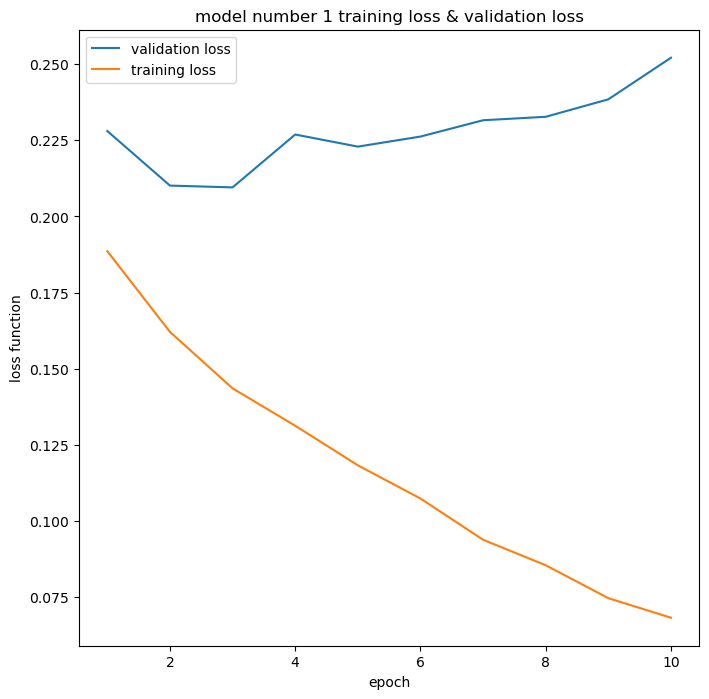

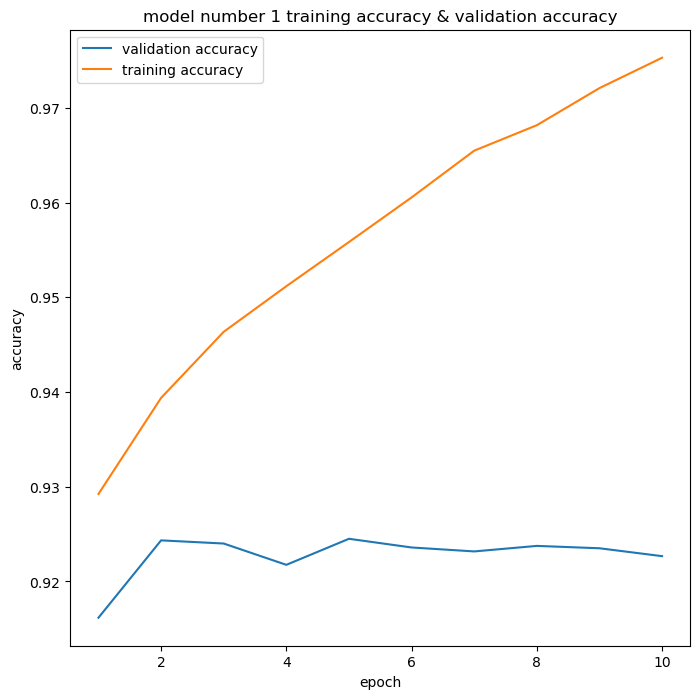

Epoch 1/30
375/375 [==============================] - 2s 4ms/step - loss: 0.2234 - accuracy: 0.9159 - val_loss: 0.2436 - val_accuracy: 0.9122
Epoch 2/30
375/375 [==============================] - 1s 3ms/step - loss: 0.1961 - accuracy: 0.9260 - val_loss: 0.2466 - val_accuracy: 0.9070
Epoch 3/30
375/375 [==============================] - 1s 3ms/step - loss: 0.1778 - accuracy: 0.9331 - val_loss: 0.2328 - val_accuracy: 0.9168
Epoch 4/30
375/375 [==============================] - 1s 3ms/step - loss: 0.1611 - accuracy: 0.9389 - val_loss: 0.2441 - val_accuracy: 0.9155
Epoch 5/30
375/375 [==============================] - 1s 3ms/step - loss: 0.1465 - accuracy: 0.9458 - val_loss: 0.2299 - val_accuracy: 0.9214
Epoch 6/30
375/375 [==============================] - 1s 3ms/step - loss: 0.1312 - accuracy: 0.9498 - val_loss: 0.2547 - val_accuracy: 0.9146
Epoch 7/30
375/375 [==============================] - 1s 3ms/step - loss: 0.1175 - accuracy: 0.9559 - val_loss: 0.2546 - val_accuracy: 0.9188
Epoch 

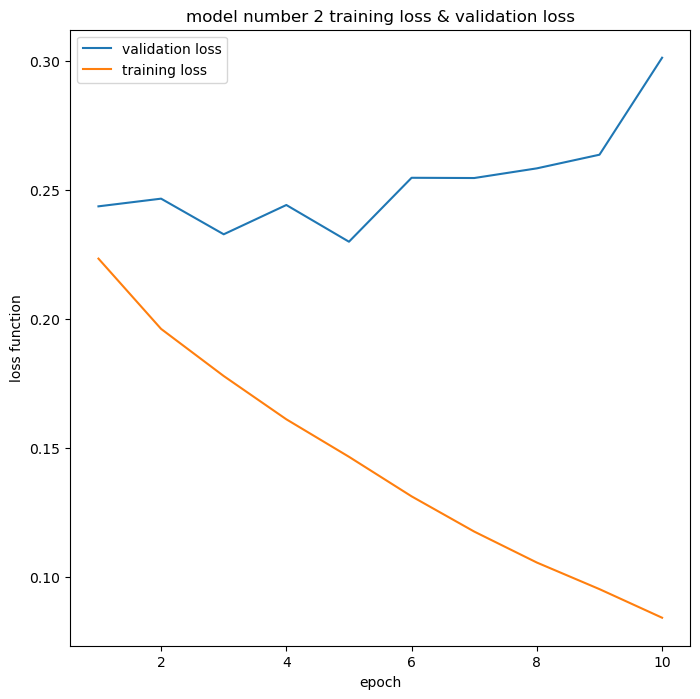

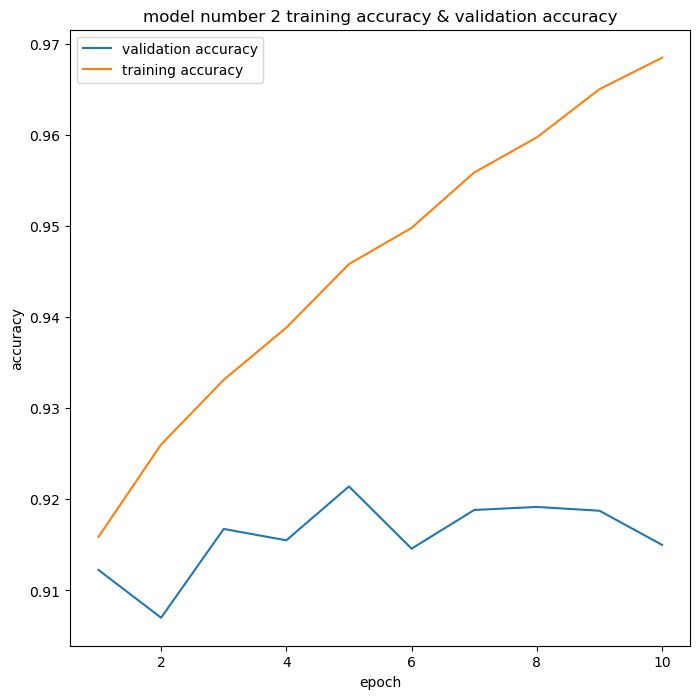

Epoch 1/30
375/375 [==============================] - 3s 7ms/step - loss: 0.2304 - accuracy: 0.9139 - val_loss: 0.2475 - val_accuracy: 0.9115
Epoch 2/30
375/375 [==============================] - 3s 7ms/step - loss: 0.2053 - accuracy: 0.9238 - val_loss: 0.2439 - val_accuracy: 0.9113
Epoch 3/30
375/375 [==============================] - 3s 7ms/step - loss: 0.1892 - accuracy: 0.9306 - val_loss: 0.2470 - val_accuracy: 0.9098
Epoch 4/30
375/375 [==============================] - 3s 7ms/step - loss: 0.1731 - accuracy: 0.9367 - val_loss: 0.2407 - val_accuracy: 0.9143
Epoch 5/30
375/375 [==============================] - 3s 7ms/step - loss: 0.1626 - accuracy: 0.9406 - val_loss: 0.2409 - val_accuracy: 0.9136
Epoch 6/30
375/375 [==============================] - 3s 7ms/step - loss: 0.1500 - accuracy: 0.9458 - val_loss: 0.2478 - val_accuracy: 0.9128
Epoch 7/30
375/375 [==============================] - 3s 7ms/step - loss: 0.1393 - accuracy: 0.9489 - val_loss: 0.2449 - val_accuracy: 0.9162
Epoch 

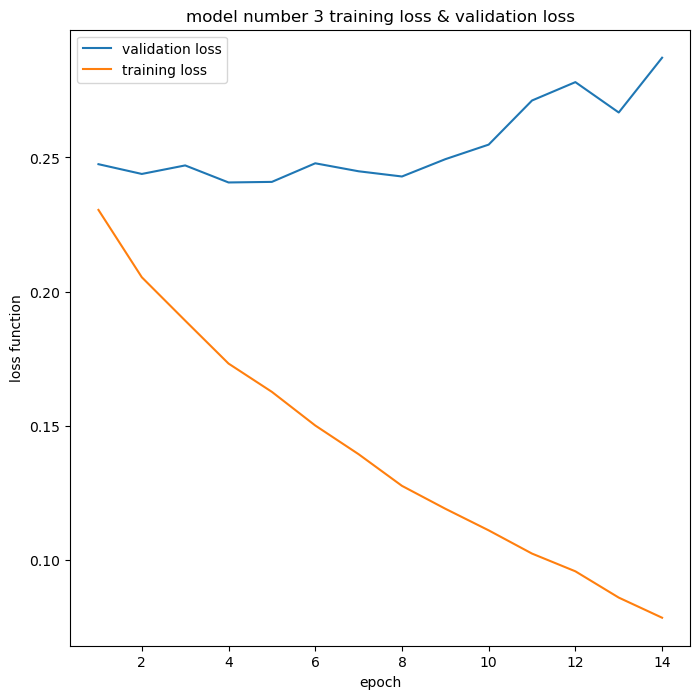

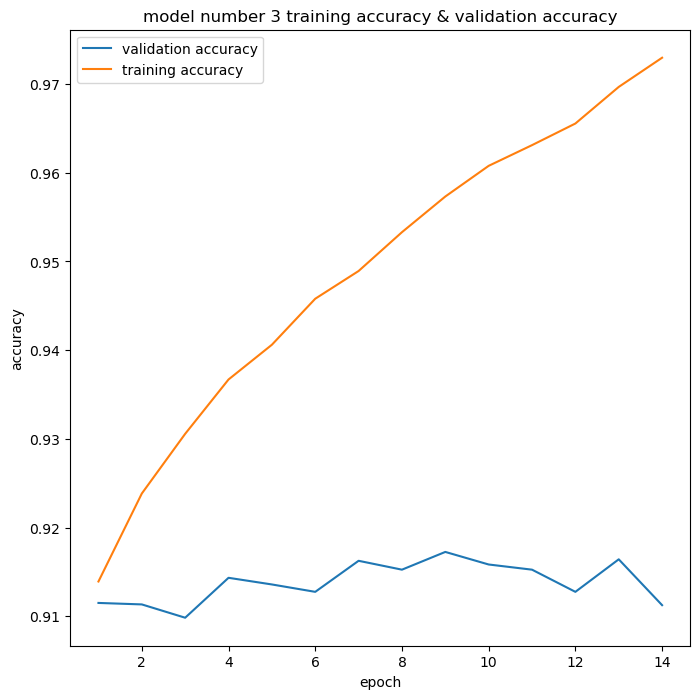

Epoch 1/30
375/375 [==============================] - 2s 5ms/step - loss: 0.2594 - accuracy: 0.9021 - val_loss: 0.2690 - val_accuracy: 0.8999
Epoch 2/30
375/375 [==============================] - 2s 5ms/step - loss: 0.2407 - accuracy: 0.9106 - val_loss: 0.2501 - val_accuracy: 0.9057
Epoch 3/30
375/375 [==============================] - 2s 5ms/step - loss: 0.2279 - accuracy: 0.9145 - val_loss: 0.2748 - val_accuracy: 0.8952
Epoch 4/30
375/375 [==============================] - 2s 5ms/step - loss: 0.2162 - accuracy: 0.9200 - val_loss: 0.2447 - val_accuracy: 0.9107
Epoch 5/30
375/375 [==============================] - 2s 5ms/step - loss: 0.2018 - accuracy: 0.9245 - val_loss: 0.2569 - val_accuracy: 0.9065
Epoch 6/30
375/375 [==============================] - 2s 5ms/step - loss: 0.1952 - accuracy: 0.9274 - val_loss: 0.2473 - val_accuracy: 0.9109
Epoch 7/30
375/375 [==============================] - 2s 5ms/step - loss: 0.1900 - accuracy: 0.9279 - val_loss: 0.2599 - val_accuracy: 0.9068
Epoch 

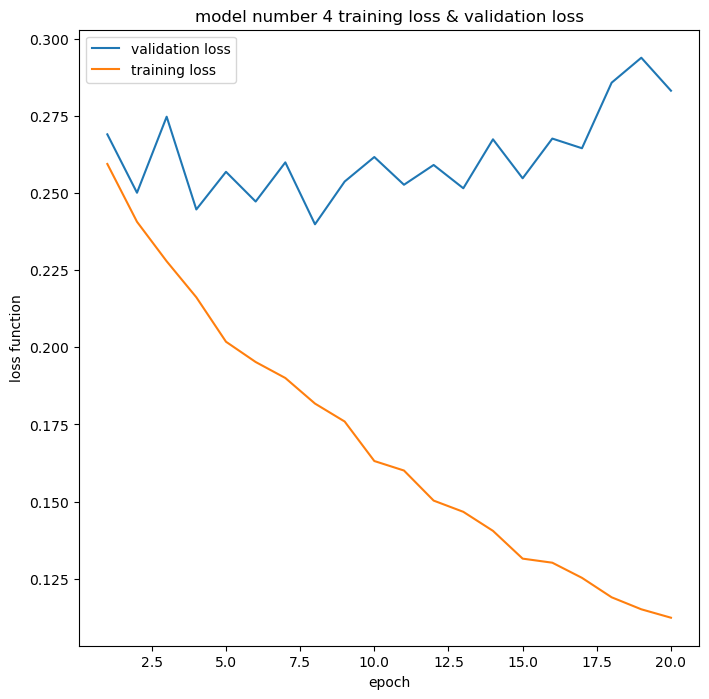

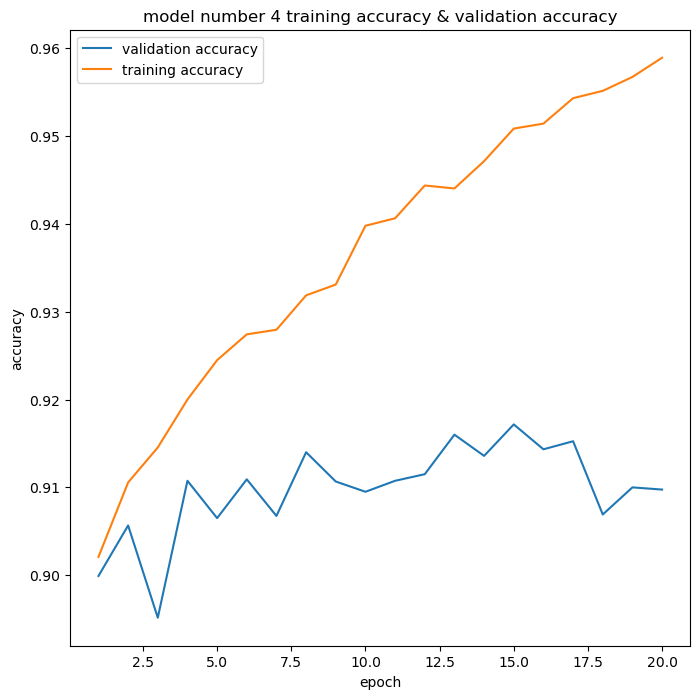

Epoch 1/30
375/375 [==============================] - 2s 6ms/step - loss: 0.2426 - accuracy: 0.9086 - val_loss: 0.2581 - val_accuracy: 0.9041
Epoch 2/30
375/375 [==============================] - 2s 5ms/step - loss: 0.2157 - accuracy: 0.9194 - val_loss: 0.2279 - val_accuracy: 0.9165
Epoch 3/30
375/375 [==============================] - 2s 5ms/step - loss: 0.1933 - accuracy: 0.9265 - val_loss: 0.2222 - val_accuracy: 0.9181
Epoch 4/30
375/375 [==============================] - 2s 5ms/step - loss: 0.1807 - accuracy: 0.9318 - val_loss: 0.2352 - val_accuracy: 0.9134
Epoch 5/30
375/375 [==============================] - 2s 5ms/step - loss: 0.1642 - accuracy: 0.9377 - val_loss: 0.2375 - val_accuracy: 0.9137
Epoch 6/30
375/375 [==============================] - 2s 5ms/step - loss: 0.1486 - accuracy: 0.9435 - val_loss: 0.2146 - val_accuracy: 0.9237
Epoch 7/30
375/375 [==============================] - 2s 5ms/step - loss: 0.1370 - accuracy: 0.9482 - val_loss: 0.2341 - val_accuracy: 0.9174
Epoch 

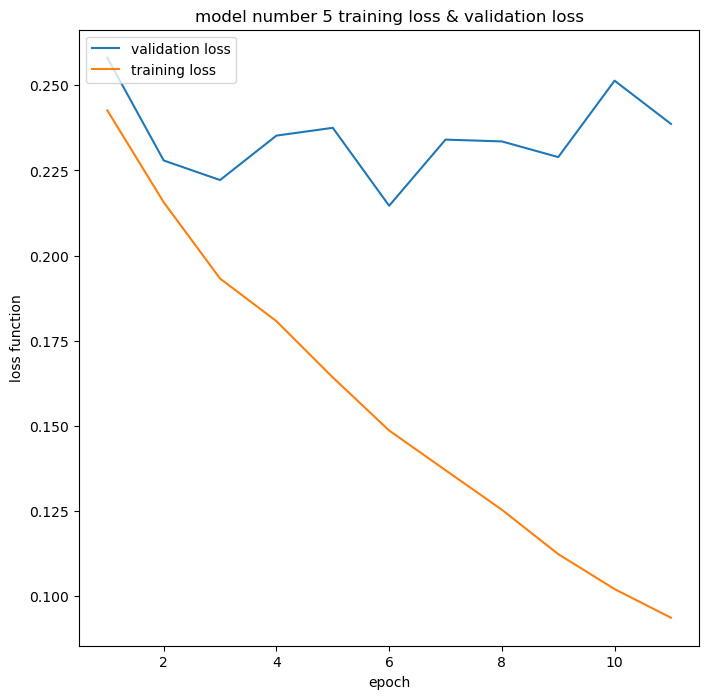

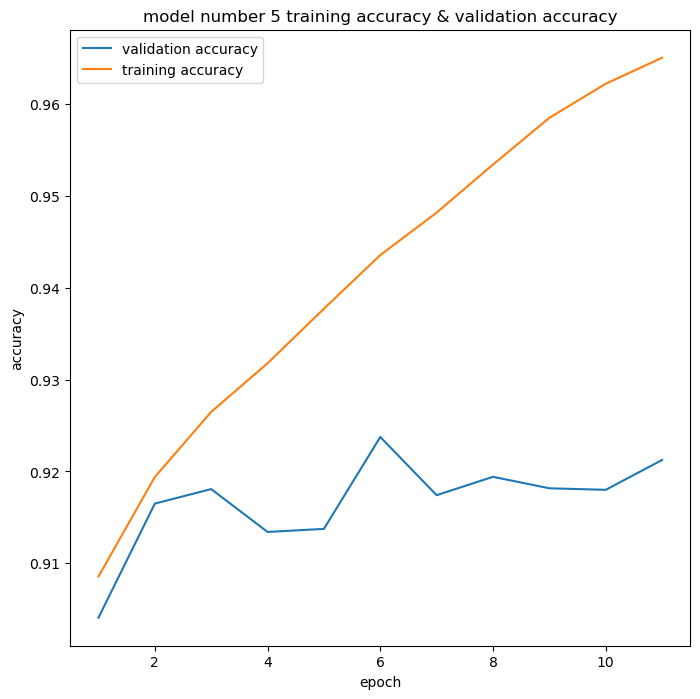

In [23]:
list_OF_Val_Loss=[]
list_OF_Loss=[]
list_Val_accuracy=[]
list_accuracy=[]

best_model = tuner.get_best_models(num_models=5)[:]
for i in range (5):
    best_model[i].build(x_train.shape)
    history=best_model[i].fit(X_train,y_train,validation_data=(X_val, y_val),callbacks=[early_stop],batch_size=128,epochs=30)

    val_loss_per_epoch = history.history['val_loss']
    loss_per_epoch = history.history['loss']
    val_accuracy_per_epoch = history.history['val_accuracy']
    accuracy_per_epoch = history.history['accuracy']

    list_OF_Val_Loss.append(val_loss_per_epoch)
    list_OF_Loss.append(loss_per_epoch)
    list_Val_accuracy.append(val_accuracy_per_epoch)
    list_accuracy.append(accuracy_per_epoch)

    plt.figure(figsize=(8,8))
    plt.title(f"model number {i+1} training loss & validation loss")
    plt.xlabel('epoch')
    plt.ylabel('loss function')
    plt.plot(np.arange(1,len(val_loss_per_epoch)+1),val_loss_per_epoch,label="validation loss")
    plt.plot(np.arange(1,len(loss_per_epoch)+1),loss_per_epoch,label = "training loss")
    plt.legend(loc="upper left")
    plt.show()

    plt.figure(figsize=(8,8))
    plt.title(f"model number {i+1} training accuracy & validation accuracy")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(np.arange(1,len(val_accuracy_per_epoch)+1),val_accuracy_per_epoch,label="validation accuracy")
    plt.plot(np.arange(1,len(accuracy_per_epoch)+1),accuracy_per_epoch,label = "training accuracy")
    plt.legend(loc="upper left")
    plt.show()


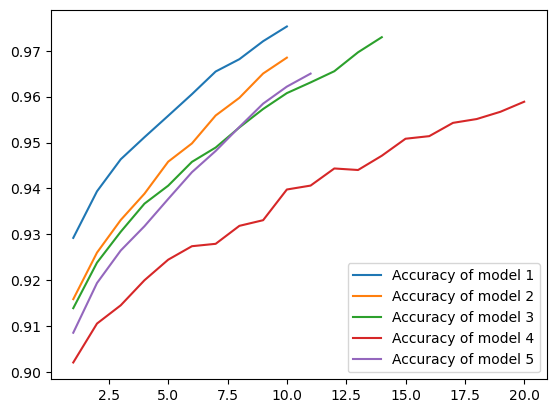

In [24]:
# here we plot the first fifth models for compare Accuracy

for i in range (5):
  plt.plot(np.arange(1,len(list_accuracy[i])+1), list_accuracy[i], label = "Accuracy of model "+str(i+1))

plt.legend()
plt.show()

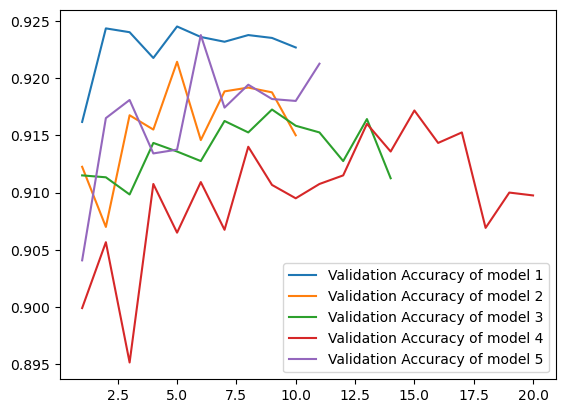

In [25]:
# here we plot the first fifth models for compare Validation Accuracy
for i in range (5):
  plt.plot(np.arange(1,len(list_Val_accuracy[i])+1), list_Val_accuracy[i], label = "Validation Accuracy of model "+str(i+1))
plt.legend()
plt.show()

In [26]:

# Evaluate the best model.
loss, accuracy = best_model[0].evaluate(X_Test, y_test)
print("Accuracy of Testing : ",accuracy)
print("Loss Of Testing : ",loss)

313/313 [==============================] - 1s 2ms/step - loss: 0.2586 - accuracy: 0.9214
Accuracy of Testing :  0.9214000105857849
Loss Of Testing :  0.2585798501968384


In [27]:
# Evaluate the best model.
loss, accuracy = best_model[1].evaluate(X_Test, y_test)
print("Accuracy of Testing : ",accuracy)
print("Loss Of Testing : ",loss)

313/313 [==============================] - 1s 2ms/step - loss: 0.3205 - accuracy: 0.9117
Accuracy of Testing :  0.9117000102996826
Loss Of Testing :  0.32053321599960327


In [28]:
loss, accuracy = best_model[2].evaluate(X_Test, y_test)
print("Accuracy of Testing : ",accuracy)
print("Loss Of Testing : ",loss)

313/313 [==============================] - 1s 2ms/step - loss: 0.3019 - accuracy: 0.9072
Accuracy of Testing :  0.9071999788284302
Loss Of Testing :  0.3018837571144104


# k-fold Cross validation

In [31]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, hist = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = tuner.get_best_models(num_models=5)[0]
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        tf.debugging.set_log_device_placement(True)
        history = model.fit(trainX, trainY, epochs=30, batch_size=128, validation_data=(testX, testY), verbose=1)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=1)
        print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        hist.append(history)
    return scores, hist

In [32]:
scor,his=evaluate_model(X,Y_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 16)        416       
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 16)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 128)       51328     
                                                                 
 average_pooling2d_1 (Averag  (None, 6, 6, 128)        0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 448)               2

In [33]:
scor

[0.9240000247955322,
 0.9279999732971191,
 0.9253333210945129,
 0.9262499809265137,
 0.9245833158493042]

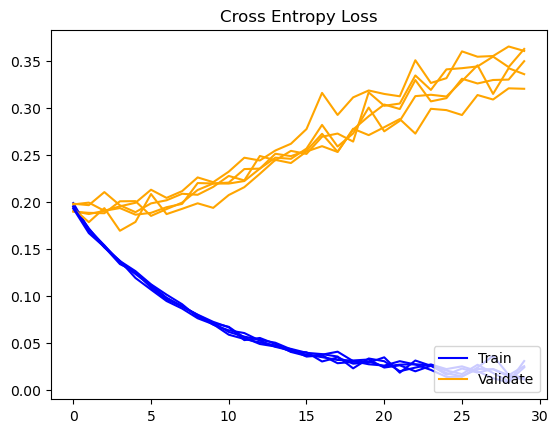

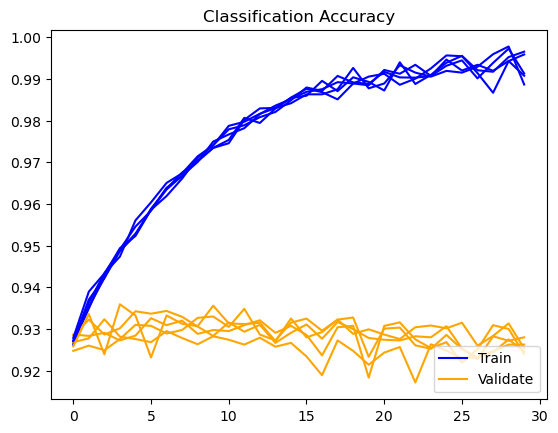

In [34]:
#  learning curves
for i in range(len(his)):
    # plot loss
    plt.title('Cross Entropy Loss')
    plt.plot(his[i].history['loss'], color='blue', label='train')
    plt.plot(his[i].history['val_loss'], color='orange', label='validate')
plt.legend(["Train", "Validate"], loc ="lower right")    
plt.show() 
     
for i in range(len(his)):

    # plot accuracy
    plt.title('Classification Accuracy')
    plt.plot(his[i].history['accuracy'], color='blue', label='train')
    plt.plot(his[i].history['val_accuracy'], color='orange', label='validate') 
plt.legend(["Train", "Validate"], loc ="lower right")    
plt.show() # For Accuracy

# EfficientNetV2B3

In [4]:
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.image import resize

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print ("Before Expanding Dim : ")
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# expand new axis, channel axis 
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# [optional]: we may need 3 channel (instead of 1)
x_train = np.repeat(x_train, 3, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)

# it's always better to normalize 
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# resize the input shape , i.e. old shape: 28, new shape: 32
x_trainE = tf.image.resize(x_train, [32,32]) # if we want to resize 
x_testE = tf.image.resize(x_test, [32,32]) # if we want to resize 
print ("After Expanding Dim : ")
print(x_trainE.shape, y_train.shape)
print(x_testE.shape, y_test.shape)
# Load EfficientNetV2B3 model with imagenet weights and exclude top layer

model =EfficientNetV2B3(weights="imagenet", include_top=False)
x = model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(10,activation='softmax')(x)
model_final = tf.keras.Model( model.input,outputs=out)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.2,min_lr=1e-6)
# Compile and train the model
model_final.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history=model_final.fit(x_trainE, y_train, batch_size=128,validation_split=0.2,epochs=30, callbacks=[reduce_lr,callback])

Before Expanding Dim : 
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
After Expanding Dim : 
(60000, 32, 32, 3) (60000,)
(10000, 32, 32, 3) (10000,)
Epoch 1/30
375/375 [==============================] - 32s 55ms/step - loss: 0.7333 - accuracy: 0.7437 - val_loss: 2.0362 - val_accuracy: 0.2463 - lr: 0.0010
Epoch 2/30
375/375 [==============================] - 19s 51ms/step - loss: 0.3745 - accuracy: 0.8743 - val_loss: 2.3183 - val_accuracy: 0.1267 - lr: 0.0010
Epoch 3/30
375/375 [==============================] - 19s 51ms/step - loss: 0.3112 - accuracy: 0.8934 - val_loss: 2.7658 - val_accuracy: 0.1720 - lr: 0.0010
Epoch 4/30
375/375 [==============================] - 19s 50ms/step - loss: 0.2701 - accuracy: 0.9073 - val_loss: 0.6047 - val_accuracy: 0.7802 - lr: 0.0010
Epoch 5/30
375/375 [==============================] - 19s 51ms/step - loss: 0.2523 - accuracy: 0.9149 - val_loss: 2.7860 - val_accuracy: 0.1367 - lr: 0.0010
Epoch 6/30
375/375 [==============================] - 19s 50ms

Text(0, 0.5, 'Losses')

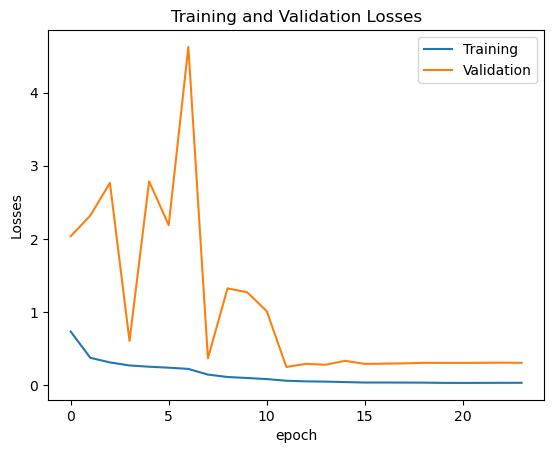

In [5]:
history.history.keys()
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Losses')
plt.xlabel('epoch')
plt.ylabel('Losses')

Text(0, 0.5, 'accuracy')

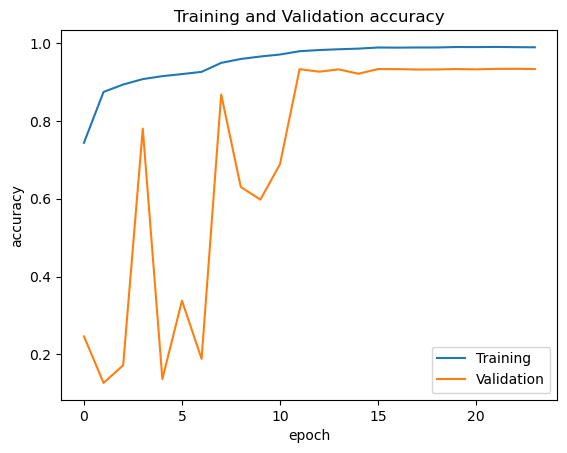

In [6]:
history.history.keys()
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [11]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model_final.evaluate(x_testE, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 3s 26ms/step - loss: 0.3484 - accuracy: 0.9258
test loss, test acc: [0.3483932912349701, 0.9258000254631042]


# DenseNet201

In [39]:
keras.backend.clear_session()

print ("Before Expanding Dim : ")
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# resize the input shape , i.e. old shape: 28, new shape: 32
x_traind = tf.image.resize(x_train, [32,32]) # if we want to resize 
x_testd = tf.image.resize(x_test, [32,32]) # if we want to resize 
print ("After Expanding Dim : ")
print(x_traind.shape, y_train.shape)
print(x_testd.shape, y_test.shape)

from keras.applications.densenet import DenseNet201
base_model = DenseNet201(weights='imagenet',include_top=False)

x = base_model.output
x = tf.keras.layers.Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
output = tf.keras.layers.Dense(10,activation = 'softmax')(x)
for layer in base_model.layers:
    layer.trainable = False
# bind all
DenseNet201_model = tf.keras.Model(base_model.input, output)
DenseNet201_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history=DenseNet201_model.fit(x_traind, y_train, batch_size=128,validation_split=0.2,epochs=30, callbacks=[reduce_lr,callback])

Before Expanding Dim : 
(60000, 28, 28, 3) (60000,)
(10000, 28, 28, 3) (10000,)
After Expanding Dim : 
(60000, 32, 32, 3) (60000,)
(10000, 32, 32, 3) (10000,)
Epoch 1/30
375/375 [==============================] - 21s 40ms/step - loss: 0.6869 - accuracy: 0.7578 - val_loss: 0.4625 - val_accuracy: 0.8316 - lr: 0.0010
Epoch 2/30
375/375 [==============================] - 13s 34ms/step - loss: 0.5358 - accuracy: 0.8034 - val_loss: 0.4286 - val_accuracy: 0.8372 - lr: 0.0010
Epoch 3/30
375/375 [==============================] - 13s 34ms/step - loss: 0.5075 - accuracy: 0.8124 - val_loss: 0.4120 - val_accuracy: 0.8486 - lr: 0.0010
Epoch 4/30
375/375 [==============================] - 13s 34ms/step - loss: 0.4838 - accuracy: 0.8213 - val_loss: 0.4091 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 5/30
375/375 [==============================] - 13s 34ms/step - loss: 0.4656 - accuracy: 0.8249 - val_loss: 0.3944 - val_accuracy: 0.8558 - lr: 0.0010
Epoch 6/30
375/375 [==============================] - 13

Text(0, 0.5, 'Losses')

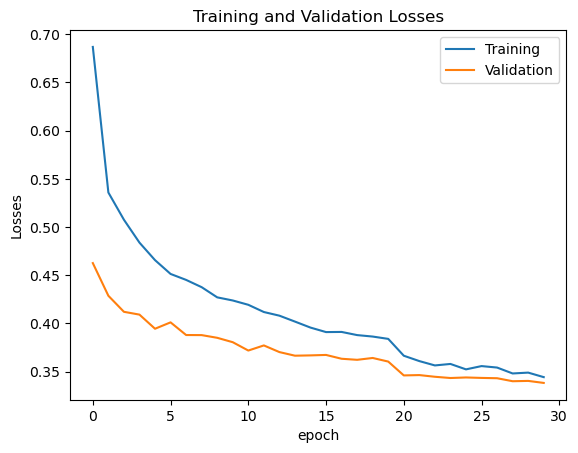

In [40]:
history.history.keys()
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Losses')
plt.xlabel('epoch')
plt.ylabel('Losses')

Text(0, 0.5, 'accuracy')

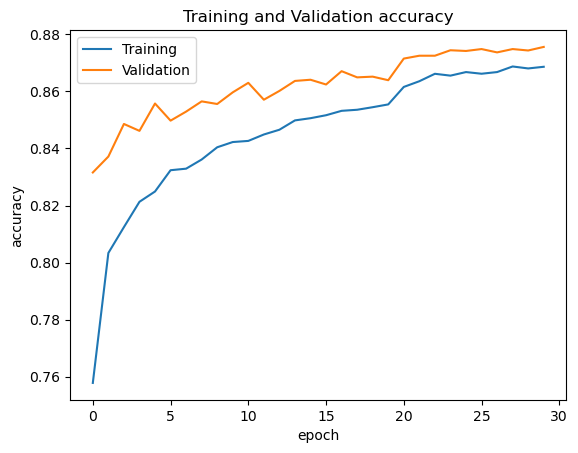

In [41]:
history.history.keys()
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [42]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = DenseNet201_model.evaluate(x_testd, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 2s 30ms/step - loss: 0.3501 - accuracy: 0.8730
test loss, test acc: [0.3500940799713135, 0.8730000257492065]


In [7]:
keras.backend.clear_session()

print ("Before Expanding Dim : ")
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# resize the input shape , i.e. old shape: 28, new shape: 32
x_traind = tf.image.resize(x_train, [32,32]) # if we want to resize 
x_testd = tf.image.resize(x_test, [32,32]) # if we want to resize 
print ("After Expanding Dim : ")
print(x_traind.shape, y_train.shape)
print(x_testd.shape, y_test.shape)

from keras.applications.densenet import DenseNet201
base_model = DenseNet201(weights='imagenet',include_top=False)

x = base_model.output
x = tf.keras.layers.Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
output = tf.keras.layers.Dense(10,activation = 'softmax')(x)
# bind all
DenseNet201_model = tf.keras.Model(base_model.input, output)
DenseNet201_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history=DenseNet201_model.fit(x_traind, y_train, batch_size=128,validation_split=0.2,epochs=30, callbacks=[reduce_lr,callback])

Before Expanding Dim : 
(60000, 28, 28, 3) (60000,)
(10000, 28, 28, 3) (10000,)
After Expanding Dim : 
(60000, 32, 32, 3) (60000,)
(10000, 32, 32, 3) (10000,)
Epoch 1/30
375/375 [==============================] - 52s 105ms/step - loss: 0.4234 - accuracy: 0.8538 - val_loss: 0.3320 - val_accuracy: 0.8876 - lr: 0.0010
Epoch 2/30
375/375 [==============================] - 38s 101ms/step - loss: 0.2565 - accuracy: 0.9084 - val_loss: 0.3426 - val_accuracy: 0.8788 - lr: 0.0010
Epoch 3/30
375/375 [==============================] - 38s 103ms/step - loss: 0.2229 - accuracy: 0.9202 - val_loss: 0.4411 - val_accuracy: 0.8622 - lr: 0.0010
Epoch 4/30
375/375 [==============================] - 38s 100ms/step - loss: 0.1953 - accuracy: 0.9295 - val_loss: 0.2701 - val_accuracy: 0.9060 - lr: 0.0010
Epoch 5/30
375/375 [==============================] - 39s 105ms/step - loss: 0.1827 - accuracy: 0.9345 - val_loss: 0.3409 - val_accuracy: 0.8827 - lr: 0.0010
Epoch 6/30
375/375 [==============================]

Text(0, 0.5, 'Losses')

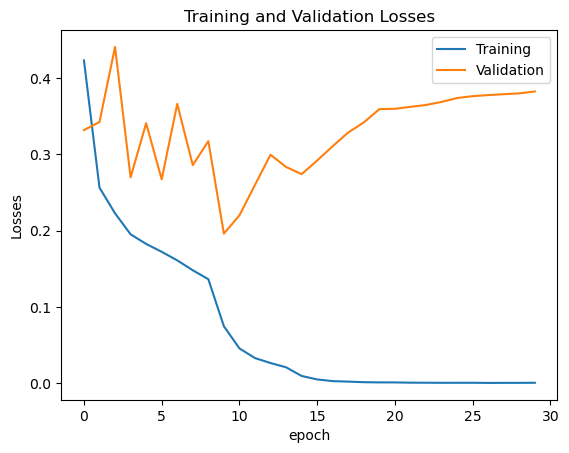

In [8]:
history.history.keys()
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Losses')
plt.xlabel('epoch')
plt.ylabel('Losses')

Text(0, 0.5, 'accuracy')

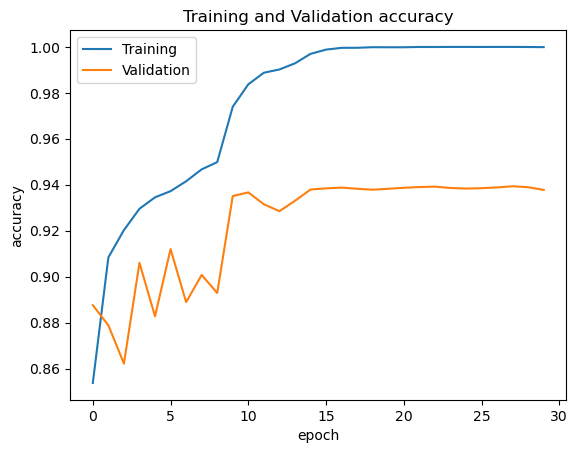

In [9]:
history.history.keys()
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [10]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = DenseNet201_model.evaluate(x_testd, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 3s 39ms/step - loss: 0.4398 - accuracy: 0.9319
test loss, test acc: [0.43980199098587036, 0.9319000244140625]


- LeNet-5 0.921 
- EfficientNetV2B3 0.925
- DenseNet201_model with freezing 0.873
- DenseNet201_model without freezing 0.931